# Image Classification with Transfer Learning 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, InputLayer, GlobalAveragePooling2D, Activation, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.callbacks import Callback
from keras import optimizers
from keras import applications
from keras.utils import np_utils

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from IPython.display import display
%matplotlib inline

Using TensorFlow backend.


### Helper functions

In [2]:
from sklearn.datasets import load_files
from functools import partial

# define function to load train, test, and validation datasets
def load_dataset(path, num_classes):
    data = load_files(path)
    files = np.array(data.filenames)
    targets = np_utils.to_categorical(np.array(data.target), num_classes=num_classes)
    
    return files, targets, data.target_names


def path_to_3d_tensor(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    return img_array / 255

    
def dataset_to_4d_tensor(path, num_classes, target_size, num_of_image_to_load=None):
    files, y, classes = load_dataset(path, num_classes)
    
    if not num_of_image_to_load:
        num_of_image_to_load = len(files)
    
    X=[]
        
    for f in files[:num_of_image_to_load]:
        X.append(path_to_3d_tensor(f, target_size))
        
    return np.array(X), y[:num_of_image_to_load], classes


### Preparations 

In [3]:
# dimensions of our images.
img_width, img_height = 224, 224

# data locations
train_data_dir = 'data/train'
valid_data_dir = 'data/valid'
test_data_dir = 'data/test'

# saved model directory
saved_model_dir = 'saved_models_capstone'

nb_train_samples = 1460
nb_valid_samples = 180
nb_test_samples = 140

batch_size = 20

if not os.path.exists(saved_model_dir):
    os.mkdir(saved_model_dir)

### Load Datasets

In [4]:
X_train, y_train, classes = dataset_to_4d_tensor(train_data_dir, 19, (img_width, img_height))
X_valid, y_valid, classes1 = dataset_to_4d_tensor(valid_data_dir, 19, (img_width, img_height))
X_test, y_test, classes2 = dataset_to_4d_tensor(test_data_dir, 19, (img_width, img_height))

print('Training   data loaded: {}'.format(X_train.shape))
print('Validation data loaded: {}'.format(X_valid.shape))
print('Test       data loaded: {}'.format(X_test.shape))

## classes should be the same
assert(classes == classes1 == classes2)

Training   data loaded: (1460, 224, 224, 3)
Validation data loaded: (180, 224, 224, 3)
Test       data loaded: (140, 224, 224, 3)


# I. Explore DataSet

### Visualize Images
The images are RGB images (3 channels) taken from different angles in the wild. This creates more difficulties for the models to learn from so little data. 
For instance, horns of the goat are of different shape looking from the side and the front. Apart from that, some images have more than one animals which could further reduce the effectiveness of the model.

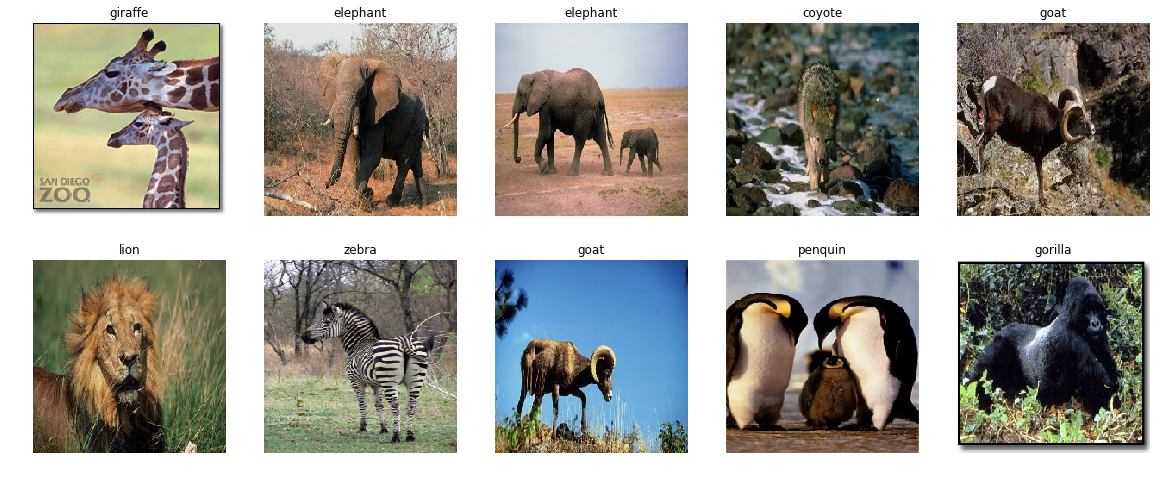

In [5]:
plt.figure(figsize=(20, 8))

for i, (X, y) in enumerate(zip(X_train[:10], y_train[:10])):
    plt.subplot(2, 5, 1 + i)
    plt.title(classes[np.argmax(y)])
    plt.axis('off')
    plt.imshow(X)
    

### Check image count of classes
Except for sheep and skunk - the images per classes are quite evenly distributed 

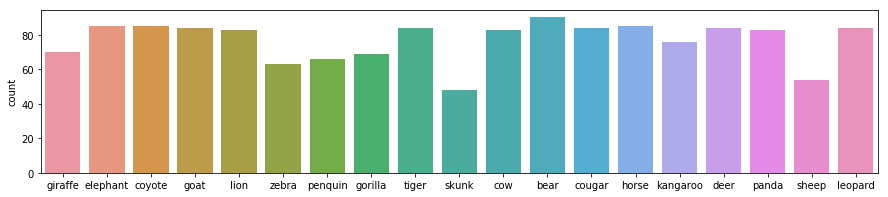

In [6]:
plt.figure(figsize=(15,3))
sns.countplot([classes[i] for i in np.argmax(y_train, axis=1)]);

# II. Benchmark Model
### Helper Class, function and generator

In [7]:
class Metric(Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test 
        self.y_test = y_test 
        self.history = pd.DataFrame(columns = ['epoch', 'metric', 'train', 'valid', 'test'])
        self.test_loss = 0
        self.test_acc = 0

    def on_epoch_end(self, epoch, logs={}):
        losses = [epoch, 'loss']
        accuracies = [epoch, 'acc']

        # Get test loss and acc
        loss, acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        
        # Prepare row
        losses += [logs['loss'], logs['val_loss'], loss]
        accuracies += [logs['acc'], logs['val_acc'], acc]
        
        # Add to DataFrame
        self.history.loc[epoch * 2] = losses
        self.history.loc[epoch * 2 + 1] = accuracies
        

        
def plot_metric_history(metric_history):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)

    sns.color_palette("pastel")

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    metric_history[metric_history.metric == 'loss'].set_index('epoch').plot(ax=ax[0])
    metric_history[metric_history.metric == 'acc'].set_index('epoch').plot(ax=ax[1])
    
    
def get_min_loss_metric(metric_history):
    min_val_loss = metric_history[metric_history.metric == 'loss'].valid.min()
    min_val_epoch = metric_history[(metric_history.valid == min_val_loss) & (metric_history.metric == 'loss')].epoch
    
    return metric_history[metric_history.epoch == int(min_val_epoch.head(1))]
    

# Create Image Generator for train, validation and test datasets
datagen = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

datagen.fit(X_train)

### Augmented Images

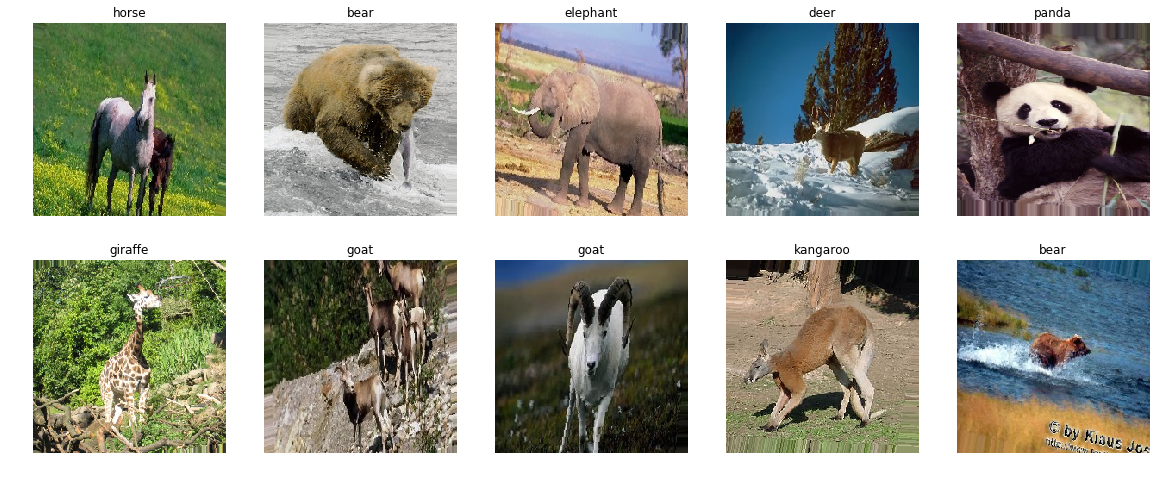

In [8]:
X_train_augmented, y_train_augmented = datagen.flow(X_train, y_train, batch_size=10, shuffle=True, seed=1).next()

plt.figure(figsize=(20, 8))

for i, (X, y) in enumerate(zip(X_train_augmented, y_train_augmented)):
    plt.subplot(2, 5, 1 + i)
    plt.title(classes[np.argmax(y)])
    plt.axis('off')
    plt.imshow(X)
    

### Benchmark Model Definition

In [9]:
MODEL=".64-5CNN"

benchmark_model = Sequential()
# Input
benchmark_model.add(InputLayer(input_shape=(img_width, img_height, 3), name='Input'))
    
benchmark_model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same', name='Conv_1'))
benchmark_model.add(MaxPool2D(name='MaxPool_2'))

benchmark_model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same', name='Conv_3'))
benchmark_model.add(MaxPool2D(name='MaxPool_4'))

benchmark_model.add(Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same', name='Conv_5'))
benchmark_model.add(MaxPool2D(name='MaxPool_5'))

benchmark_model.add(Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same', name='Conv_7'))
benchmark_model.add(MaxPool2D(name='MaxPool_7'))
benchmark_model.add(Dropout(0.5, name='Dropout_8'))

benchmark_model.add(Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same', name='Conv_9'))
benchmark_model.add(MaxPool2D(name='MaxPool_10'))
benchmark_model.add(Dropout(0.4, name='Dropout_11'))

benchmark_model.add(GlobalAveragePooling2D(name='GAP_12'))
benchmark_model.add(Dropout(0.3, name='Dropout_13'))

# Output
benchmark_model.add(Dense(19, activation='softmax', name='Output'))

## Compile Model
benchmark_model.compile(optimizer=optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

## View Model
benchmark_model.summary()

## Model Output
benchmark_model_weights_path = f'{saved_model_dir}/benchmark_model{MODEL}.{img_width}x{img_height}.weights.best.hdf5'
benchmark_model_metric_path = f'{saved_model_dir}/benchmark_model{MODEL}.{img_width}x{img_height}.metric.hdf5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 112, 112, 64)      0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 112, 112, 128)     73856     
_________________________________________________________________
MaxPool_4 (MaxPooling2D)     (None, 56, 56, 128)       0         
_________________________________________________________________
Conv_5 (Conv2D)              (None, 56, 56, 256)       295168    
_________________________________________________________________
MaxPool_5 (MaxPooling2D)     (None, 28, 28, 256)       0         
__________

In [10]:
epochs = 100 
retrain=True

train_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=1)

## Train 
if retrain or not os.path.exists(benchmark_model_weights_path):
    checkpointer = ModelCheckpoint(filepath=benchmark_model_weights_path, monitor='val_loss', verbose=1, save_best_only=True, )
    earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    benchmark_metric = Metric(X_test, y_test)
    
    start_time = timeit.default_timer()

    benchmark_model.fit_generator(
                train_data_generator,
                validation_data=(X_valid, y_valid),
                steps_per_epoch = len(X_train) / batch_size,
                epochs=epochs,
                callbacks=[checkpointer, earlystopper, benchmark_metric], 
                verbose=0)
    
    print('\nModel took {:.2f} seconds to train.'.format(timeit.default_timer() - start_time))
    
    benchmark_metric.history.to_pickle(benchmark_model_metric_path)
else:
    print('Model has already been trained.')

Epoch 00000: val_loss improved from inf to 2.93397, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 2.93397 to 2.90994, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00003: val_loss improved from 2.90994 to 2.54580, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00004: val_loss improved from 2.54580 to 2.52379, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00005: val_loss improved from 2.52379 to 2.37080, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00006: val_loss improved from 2.37080 to 2.27245, saving model to saved_models_capstone/benchmark_model.64-5CNN.224x224.weights.best.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 2.27245 to 2.26769, saving m

,epoch,metric,train,valid,test
46,23,loss,1.117020,1.356680,1.826603
47,23,acc,0.659589,0.627778,0.571429


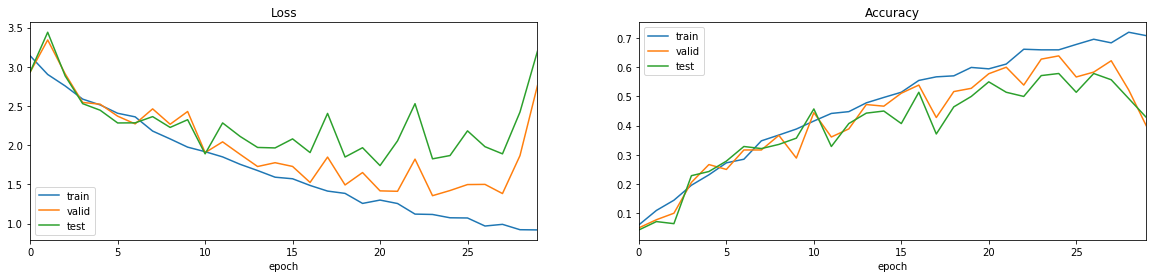

In [11]:
import timeit

benchmark_model.load_weights(benchmark_model_weights_path)
benchmark_metric_history = pd.read_pickle(benchmark_model_metric_path)

plot_metric_history(benchmark_metric_history)
display(get_min_loss_metric(benchmark_metric_history))

# III. Transfer Learning - Train a top model based on a pretrain model
## Generate bottleneck features 
Bottleneck features are the output of the pretrained model at the point before fully-connected layer.
At this stage, I'll use a pretrain model with weights trained from imagenet dataset - and connect it with a fully-connected layer (2 categories) for our dog-vs-cat problem.

In [12]:
## Load pre-trained network
pretrained_model = applications.VGG19(include_top=False, weights='imagenet')

bottleneck_features_train_data = f'{saved_model_dir}/{pretrained_model.name}.{img_width}x{img_height}.bottleneck_features_train.npy'
bottleneck_features_valid_data = f'{saved_model_dir}/{pretrained_model.name}.{img_width}x{img_height}.bottleneck_features_valid.npy'
bottleneck_features_test_data = f'{saved_model_dir}/{pretrained_model.name}.{img_width}x{img_height}.bottleneck_features_test.npy'

train_X_generator = datagen.flow(X_train, batch_size=batch_size, shuffle=False)

## Generate bottleneck features - output of pretrained model
# Training
if not os.path.exists(bottleneck_features_train_data):
    X_train_bottleneck = pretrained_model.predict_generator(train_X_generator, steps=len(X_train) / batch_size)
    np.save(open(bottleneck_features_train_data, 'wb'), X_train_bottleneck)
    print('Training   bottleneck features saved.')
else:
    print('Training   bottleneck features already exist.')

# Validation
if not os.path.exists(bottleneck_features_valid_data):
    X_valid_bottleneck = pretrained_model.predict(X_valid)
    np.save(open(bottleneck_features_valid_data, 'wb'), X_valid_bottleneck)
    print('Validation bottleneck features saved.')
else:
    print('Validation bottleneck features already exist.')
    
# Testing
if not os.path.exists(bottleneck_features_test_data):
    X_test_bottleneck = pretrained_model.predict(X_test)
    np.save(open(bottleneck_features_test_data, 'wb'), X_test_bottleneck)
    print('Testing    bottleneck features saved.')
else:
    print('Testing    bottleneck features already exist.')

Training   bottleneck features saved.
Validation bottleneck features saved.
Testing    bottleneck features saved.


## Define Top Model

In [13]:
# Inputs
X_train_bottleneck = np.load(open(bottleneck_features_train_data, 'rb'))
X_valid_bottleneck = np.load(open(bottleneck_features_valid_data, 'rb'))
X_test_bottleneck = np.load(open(bottleneck_features_test_data, 'rb'))

######### TOP MODEL ######################################
epochs = 500
retrain = True
top_model_name = 'gap' 

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=X_train_bottleneck.shape[1:], name='GAP'))
top_model.add(Dropout(0.7, name='Dropout'))
top_model.add(Dense(19, name='FC'))
top_model.add(Activation('softmax', name='Softmax'))
#top_model.add(Dense(19, activation='softmax', name='Output'))
##########################################################


#top_model.compile(optimizer=optimizers.Adamax(lr=0.025),
top_model.compile(optimizer=optimizers.RMSprop(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

top_model.summary()

top_model_weights_path = f'{saved_model_dir}/{pretrained_model.name}.{top_model_name}.{img_width}x{img_height}.top_model.weights.best.hdf5'
top_model_metric_path = f'{saved_model_dir}/{pretrained_model.name}.{top_model_name}.{img_width}x{img_height}.metric.hdf5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GAP (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
FC (Dense)                   (None, 19)                9747      
_________________________________________________________________
Softmax (Activation)         (None, 19)                0         
Total params: 9,747
Trainable params: 9,747
Non-trainable params: 0
_________________________________________________________________


## Train Top Model

In [14]:
if retrain or not os.path.exists(top_model_weights_path):

    checkpointer = ModelCheckpoint(filepath=top_model_weights_path, monitor='val_loss', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    top_metric = Metric(X_test_bottleneck, y_test)

    start_time = timeit.default_timer()
    
    top_model.fit(X_train_bottleneck, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_valid_bottleneck, y_valid),
              callbacks=[checkpointer, earlystopper, top_metric], verbose=0)
    
    print('\nTop Model took {:.2f} seconds to train.'.format(timeit.default_timer() - start_time))
    
    top_metric.history.to_pickle(top_model_metric_path)
else:
    print('Model already trained.')

Epoch 00000: val_loss improved from inf to 2.89789, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00001: val_loss improved from 2.89789 to 2.81672, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00002: val_loss improved from 2.81672 to 2.75040, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00003: val_loss improved from 2.75040 to 2.68419, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00004: val_loss improved from 2.68419 to 2.62171, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00005: val_loss improved from 2.62171 to 2.56261, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00006: val_loss improved from 2.56261 to 2.50740, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00007: val_loss im

Epoch 00061: val_loss did not improve
Epoch 00062: val_loss improved from 1.66041 to 1.65150, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00063: val_loss did not improve
Epoch 00064: val_loss improved from 1.65150 to 1.63449, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00065: val_loss improved from 1.63449 to 1.62867, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00066: val_loss did not improve
Epoch 00067: val_loss did not improve
Epoch 00068: val_loss improved from 1.62867 to 1.62627, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00069: val_loss improved from 1.62627 to 1.61386, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00070: val_loss did not improve
Epoch 00071: val_loss improved from 1.61386 to 1.60920, saving model to saved_models_capstone/vgg19.gap.224x22

Epoch 00154: val_loss did not improve
Epoch 00155: val_loss improved from 1.43100 to 1.42337, saving model to saved_models_capstone/vgg19.gap.224x224.top_model.weights.best.hdf5
Epoch 00156: val_loss did not improve
Epoch 00157: val_loss did not improve
Epoch 00158: val_loss did not improve
Epoch 00159: val_loss did not improve
Epoch 00160: val_loss did not improve
Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss did not improve
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00166: early stopping

Top Model took 31.31 seconds to train.


## Accuracy

,epoch,metric,train,valid,test
310,155,loss,1.569475,1.423375,1.455613
311,155,acc,0.530137,0.583333,0.607143


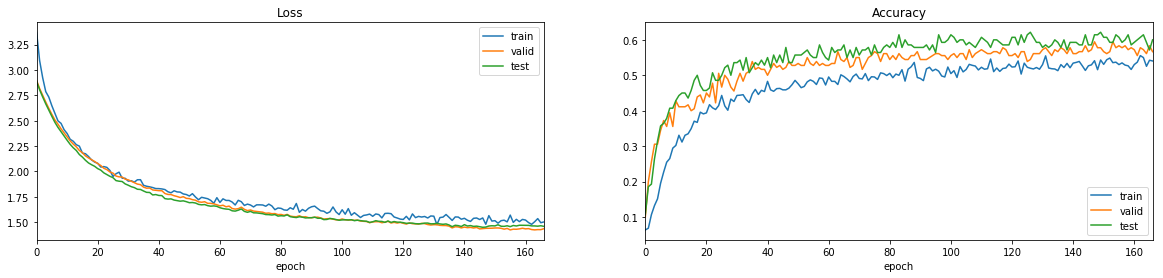

In [15]:
top_model.load_weights(top_model_weights_path)
top_metric_history = pd.read_pickle(top_model_metric_path)

plot_metric_history(top_metric_history)
display(get_min_loss_metric(top_metric_history))

# II. Fine Tune Last CNN Block
## Build model from pretrained and the top model

In [16]:
fine_tune_model_weights_path = f'{saved_model_dir}/{pretrained_model.name}.{top_model_name}.{img_width}x{img_height}.fine_tune.weights.best.hdf5'
fine_tune_model_metric_path = f'{saved_model_dir}/{pretrained_model.name}.{top_model_name}.{img_width}x{img_height}.fine_tune.metric.hdf5'

## Reload (to make sure) pretrained and top_model weight
pretrained_model = applications.VGG19(include_top=False, weights='imagenet')
top_model.load_weights(top_model_weights_path)

## Build model from pretrain and top model
model = Sequential()
for l in pretrained_model.layers:
    model.add(l)
    
for l in top_model.layers:
    model.add(l)

## Lock layers until the last ConvNet block
lock_until = 17  

for n, layer in enumerate(model.layers):
    if n < lock_until:
        layer.trainable = False
    else:
        layer.trainable = True

## Compile
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Show model layers 
Only block 5 ConvNet and the top model (FC layer) is trainable

In [17]:
for i, l in enumerate(model.layers):
    print('{:<2}: {:>27}({:^7}) - trainable={}'.format(i, l.name, l.activation.__name__ if hasattr(l,'activation') else '', l.trainable))

0 :                     input_2(       ) - trainable=False
1 :                block1_conv1( relu  ) - trainable=False
2 :                block1_conv2( relu  ) - trainable=False
3 :                 block1_pool(       ) - trainable=False
4 :                block2_conv1( relu  ) - trainable=False
5 :                block2_conv2( relu  ) - trainable=False
6 :                 block2_pool(       ) - trainable=False
7 :                block3_conv1( relu  ) - trainable=False
8 :                block3_conv2( relu  ) - trainable=False
9 :                block3_conv3( relu  ) - trainable=False
10:                block3_conv4( relu  ) - trainable=False
11:                 block3_pool(       ) - trainable=False
12:                block4_conv1( relu  ) - trainable=False
13:                block4_conv2( relu  ) - trainable=False
14:                block4_conv3( relu  ) - trainable=False
15:                block4_conv4( relu  ) - trainable=False
16:                 block4_pool(       ) - trainable=Fal

## Train
As [Keras Blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) pointed out, I have to use SGD here as optimizer - I tried RMSprop which brought the validation accuracy straight back to 50% (it's like almost restarting the entire training)

In [18]:
retrain = True
epochs = 100

if retrain or not os.path.exists(fine_tune_model_weights_path):
    checkpointer = ModelCheckpoint(filepath=fine_tune_model_weights_path, monitor='val_loss', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    metric = Metric(X_test, y_test)
    
    start_time = timeit.default_timer()

    model.fit_generator(
                train_data_generator,
                validation_data=(X_valid, y_valid),
                steps_per_epoch = len(X_train) / batch_size,
                epochs=epochs,
                callbacks=[checkpointer, earlystopper, metric], 
                verbose=0)
    
    metric.history.to_pickle(fine_tune_model_metric_path)
    
    print('\nTop Model took {:.2f} seconds to train.'.format(timeit.default_timer() - start_time))
    
else:
    print('Model already trained.')

Epoch 00000: val_loss improved from inf to 1.21229, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00001: val_loss improved from 1.21229 to 1.09220, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00002: val_loss improved from 1.09220 to 1.01601, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00003: val_loss improved from 1.01601 to 0.94834, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00004: val_loss improved from 0.94834 to 0.94068, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00005: val_loss improved from 0.94068 to 0.86704, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00006: val_loss improved from 0.86704 to 0.85252, saving model to saved_models_capstone/vgg19.gap.224x224.fine_tune.weights.best.hdf5
Epoch 00007: val_loss im

## After fine-tuning
Accuracy increased significantly after fine-tuning the last ConvNet block and the fully-connected layer (top model)

,epoch,metric,train,valid,test
82,41,loss,0.232594,0.568131,0.933875
83,41,acc,0.927397,0.822222,0.800000


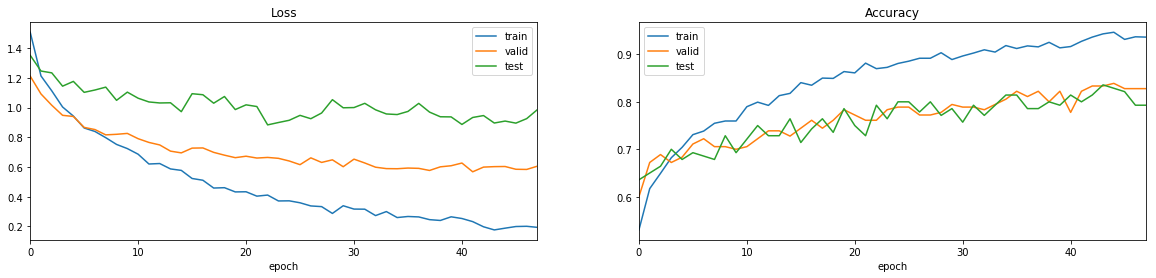

In [19]:
model.load_weights(fine_tune_model_weights_path)
fine_tune_metric_history = pd.read_pickle(fine_tune_model_metric_path)

plot_metric_history(fine_tune_metric_history)
display(get_min_loss_metric(fine_tune_metric_history))

# III. Localization

In [20]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.preprocessing import image    
from keras.models import Model   
import sys

def img_path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img) / 255   # (224, 224, 3)
    return np.expand_dims(x, axis=0) # (1, 224, 224, 3)
    
# Location of the last cnn and output layer
last_cnn_layer = -6  # the last convolution layer - before the MaxPool layer
output_layer = -2    # the last layer is softmax activation in the current setting

# Build a new model which taks the models input as input and produces two outputs - the last cnn layer and the model output layer

new_model = Model(inputs=model.input, outputs=(model.layers[last_cnn_layer].get_output_at(1), model.layers[output_layer].get_output_at(1))) 

# Test Image - not in the train/valid/test dataset
img_path = 'my_image/panda_x2.jpg'

In [21]:
# get filtered images from convolutional output + model prediction vector
last_conv_output, pred_vec = new_model.predict(img_path_to_tensor(img_path))
last_conv_output = np.squeeze(last_conv_output)  # (1, 14, 14, 512) --> (14, 14, 512)
pred = np.argmax(pred_vec) # get predicted class

# Reverse downsampling - when reaching the last Conv layer, the model downsampled 4 times from (224, 224) to (14, 14) 
#cnn_weights_zoomed = scipy.ndimage.zoom(last_conv_output, (16, 16, 1), order=1) # (14, 14, 512) --> (224, 224, 512)

# get FC layer weights
all_fc_layer_weights = model.layers[output_layer].get_weights()[0]
fc_layer_weights = all_fc_layer_weights[:, pred] * -1 # dim: (512,) 

# get class activation map for object class that is predicted to be in the image
activation_map = np.dot(last_conv_output, fc_layer_weights)

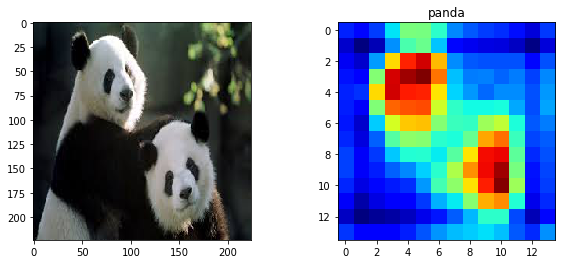

In [22]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(10)

# Show image
im = img_path_to_tensor(img_path).squeeze()
ax[0].imshow(im, alpha=1);

# Show Activation Map
ax[1].imshow(activation_map, cmap='jet')  # plot class activation map
ax[1].set_title(classes[pred]);  # show prediction class 

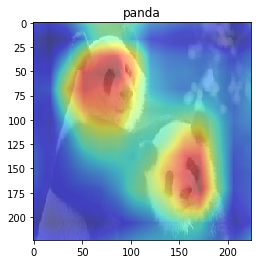

In [23]:
# upsampling
activation_map_zoomed = scipy.ndimage.zoom(activation_map, (16, 16), order=1) # 14x14 --> 224x224

# overlay
fig,ax = plt.subplots()
ax.imshow(im, alpha=0.5) # plot image
ax.imshow(activation_map_zoomed, cmap='jet', alpha=0.5)  # plot class activation map
ax.set_title(classes[pred]);  # show prediction class 